In [1]:
%load_ext autoreload
%autoreload 2
import mkl
mkl.set_num_threads(1)

48

# Imports

In [2]:
import pickle
from collections import namedtuple
from itertools import product
from copy import copy
from os.path import join

import numpy as np
import pandas as pd
import seaborn as sns
from aeff_calculations import calc_aeff_factor
from fluxes import astro_flux
import mephisto
from scipy.optimize import fmin_l_bfgs_b

from scipy.stats import chi2
import settings as st
from settings import LOCALPATH, sigma2, sigma3, sigma5, plt, colors, ngc1068
from tools import get_scaler
from likelihood import setup_multi_llh, ps_llh_multi
from tqdm import tqdm
from matplotlib.patches import Rectangle
from matplotlib.colors import LogNorm

Could not import healpy.
functions plot_area, add_catalog, and add_extended_plane will not work.


In [3]:
# energy resolution files
e_res_files = {
    # "baseline": join(LOCALPATH, "energy_smearing_GP_up.pckl"),
    "improved-50": join(
        LOCALPATH, "improved_0.5_artificial_energy_smearing_GP_up.pckl"
    ),
}


# helper functions

In [4]:
from tools import scaling_estimation

# Effective area

We use here only upgoing events with dec>-5deg, since this is the threshold for a pure data set with few muons.

In [5]:
with open(join(LOCALPATH, "effective_area_MH_upgoing.pckl"), "rb") as f:
    aeff_2d = pickle.load(f)


# Atmospheric background

In [6]:
with open(join(LOCALPATH, "atmospheric_background_daemonflux_MH.pckl"), "rb") as f:

    bckg_histo = pickle.load(f)

# check if histos are matching
print(bckg_histo["IceCube"].match(aeff_2d["IceCube"], verbose=True))
bckg_histo["Gen-2"] = bckg_histo["IceCube"]

Elementary arithmetic possible.
True


# Energy resolution function

In [7]:
# baseline resolution
# with open(e_res_files["baseline"], "rb") as f:
#     baseline_eres = pickle.load(f)
# baseline_eres.normalize(axis=1)  # normalize per logE_true

# resolution improved by 50%
with open(e_res_files["improved-50"], "rb") as f:
    improved_eres = pickle.load(f)
improved_eres.normalize(axis=1)  # normalize per logE_true

# checking if matrix multiplication is possible
print(aeff_2d["IceCube"].match_matmul(improved_eres, verbose=True))


Matrix multiplication possible.
True


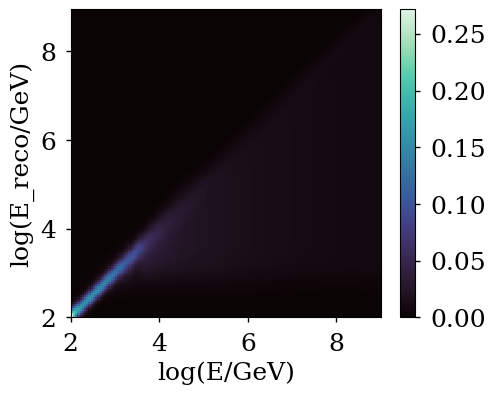

In [8]:
improved_eres.plot()

# Psi²-Energy resolution

NOTE: psi changes per detector over the day. For the sake of (optimistic) simplicity, we choose the horizontal resolution for all detectors

In [9]:
# angular resolution
with open(join(LOCALPATH, f"Psi2-{st.delta_psi_max}_res_mephistograms.pckl"), "rb") as f:
    all_psi = pickle.load(f)
e_psi2_grid = all_psi["dec-0.0"]
e_psi2_grid.normalize()

# uniform, normalized background grid
bckg_psi2_grid = mephisto.like(e_psi2_grid, fill_value=1)
bckg_psi2_grid.normalize()


# Flux definition

In [10]:
# we base the flux models on named-tuples
PL_flux = namedtuple("PL_flux", "norm gamma E0 shape")
PLcut_flux = namedtuple("PLcut_flux", "norm gamma e_cut E0 shape")
LogP_flux = namedtuple("LogP_flux", "norm alpha beta E0 shape")

flux_collection = {
    "powerlaw": PL_flux,
    "powerlaw with cutoff": PLcut_flux,
    "log-parabola": LogP_flux,
}


## NGC1068 source parameters

In [11]:
# ngc flux error contour
gamma_c_68, phi_c_68 = np.loadtxt(join(LOCALPATH, "ngc_paper_68_contour.txt"))
phi_c_68 /= 1e11
gamma_c_68_prev, phi_c_68_prev = np.loadtxt(
    join(LOCALPATH, "tenyr_paper_68_contour.txt")
)

ngc_flux = PL_flux(st.PHI_NGC, st.GAMMA_NGC, st.E0_NGC, "powerlaw")


In [12]:
# generic source config without dec coordinate
src_config = dict(
    sindec_mids=st.sindec_mids,
    livetime=st.LIVETIME,
    ewidth=st.ewidth,
    dpsi_max=0,
    grid_2d=e_psi2_grid,
)
# generic bg config
bg_config = copy(src_config)
bg_config["dpsi_max"] = st.delta_psi_max
bg_config["grid_2d"] = bckg_psi2_grid

# ... with ngc declination
ngc_src_config = copy(src_config)
ngc_src_config["dec"] = ngc1068.dec.rad
ngc_bg_config = copy(bg_config)
ngc_bg_config["dec"] = ngc1068.dec.rad


## Check event numbers

In [13]:
ident = "IceCube"
# check that the bins match
assert (aeff_2d[ident].bins[1] == ngc_src_config["grid_2d"].bins[1]).all()
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)

k_s = astro_flux(
    aeff_factor_signal,
    10 ** aeff_factor_signal.bin_mids[1],
    energy_resolution=improved_eres,
    phi_scaling=1,
    flux_shape=ngc_flux,
)
print("ngc 1068:", np.sum(k_s))  # ~85

ngc 1068: 87.49686772537285


## PL+Cut: source parameters

In [14]:
# cutoff parameters
# see energy_spectrum_wiggle.ipynb for 'optimization'
# of these parameters
print(st.Gamma_cut, st.logE_cut)

tmp_flux = PLcut_flux(st.PHI_NGC, st.Gamma_cut, st.logE_cut, st.E0_NGC, "powerlaw with cutoff")


2.0 3.4



### scale the fluxes such that the event numbers match


In [15]:
## check event numbers
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)
astro_ev_sum_pl = np.sum(
    astro_flux(
        aeff_factor_signal,
        10 ** aeff_factor_signal.bin_mids[1],
        improved_eres,
        1,
        ngc_flux,
    )
)

# cutoff
astro_ev_sum_cut = np.sum(
    astro_flux(
        aeff_factor_signal,
        10 ** aeff_factor_signal.bin_mids[1],
        improved_eres,
        1,
        tmp_flux,
    )
)
flux_scaling_cut = astro_ev_sum_pl / astro_ev_sum_cut
print("flux_scaling_cut", flux_scaling_cut)
print("flux normalization before", st.PHI_NGC, "after", st.PHI_NGC * flux_scaling_cut)

# define the correctly normalized PL+cut flux for NGC 1068
ngc_cut_flux = PLcut_flux(
    st.PHI_NGC * flux_scaling_cut,
    st.Gamma_cut,
    st.logE_cut,
    st.E0_NGC,
    "powerlaw with cutoff",
)

flux_scaling_cut 1.783528493511617
flux normalization before 5e-14 after 8.917642467558085e-14


# Livetime and detector scaling

## setup

In [16]:
icecube_ref_time = st.LIVETIME / 365 / (24*3600)  # approx. 8.7 Years of full detector (NGC 1068 analysis)

start_dates = [
    {"label": r"IceCube", "detector": "IceCube", "Year": 2020-icecube_ref_time, "colors": "0.8", "end": 2040},
    {"label": r"IceCube", "detector": "IceCube extrapolated", "Year": 2020-icecube_ref_time, "colors": "0.8", "end": 2060}, ## WIP
    {"label": r"+ 7.5$\times$ IceCube (South)", "detector": "Gen-2", "Year": 2040, "colors": "0.5", "end": 2060},
    {"label": r"+ 1$\times$ IceCube (North)", "detector": "KM3NeT", "Year": 2025, "colors": colors[2], "end": 2060},
    {"label": r"+ 1$\times$ IceCube (North)", "detector": "Baikal-GVD", "Year": 2030, "colors": colors[1], "end": 2060},
    {"label": r"+ 1$\times$ IceCube (North)", "detector": "P-ONE", "Year": 2035, "colors": colors[0], "end": 2060},
]
start_dates = pd.DataFrame(start_dates)
start_dates = start_dates.set_index("detector")
yr_max = 2055
Years = np.arange(2020, yr_max)



## standard PS analysis

### PLEnuM

In [28]:
tmp = []  # save output here
thresholds = [sigma5]
decs = [-30, 0, 30]
detector_keys = ["IceCube", "KM3NeT", "Baikal-GVD", "P-ONE", "Gen-2"]

# different energy resolutions for different detectors
eres_per_det = improved_eres

for dec, yr_i in product(decs, Years):
    rad_dec = np.deg2rad(dec)
    
    # skip Southern Sky for IceCube-only config
    if dec < 0 and yr_i <= 2025:
        continue
    
    # insert the declination into the configs
    cur_bg_conf = bg_config.copy()
    cur_bg_conf["dec"] = rad_dec

    cur_sig_conf = src_config.copy()
    cur_sig_conf["dec"] = rad_dec

    time_factors = []
    cur_dets = []
    # generate the config for this particular year
    for ident in detector_keys:
        # skip calculation if detector isn't on yet
        if yr_i <= start_dates.loc[ident]["Year"]:
            continue

        # IceCube has an end-time within our time frame (=Gen2 start-time)
        # so it has a maximum contribution time here
        if (ident == "IceCube") and (yr_i >= start_dates.loc[ident]["end"]):
            new_rel_time = (
                start_dates.loc[ident]["end"] - start_dates.loc[ident]["Year"]
            ) / icecube_ref_time
        # otherwise, just calculate the diff between start time and current time
        else:
            new_rel_time = (yr_i - start_dates.loc[ident]["Year"]) / icecube_ref_time
        time_factors.append(new_rel_time)
        cur_dets.append(ident)

    conf = (cur_dets, time_factors)
    (
        all_aeff_factor_s,
        all_aeff_factor_b,
        all_k,
        all_bckg_flux,
        all_eres,
        all_k_b,
        all_k_s,
    ) = setup_multi_llh(
        improved_eres,  # select one resolution for all data sets
        conf,
        aeff_2d=aeff_2d,
        bckg_histo=bckg_histo,
        bg_config=cur_bg_conf,
        sig_config=cur_sig_conf,
        return_s_b=True,
        src_flux=ngc_flux,
    )

    all_k_s = np.array(all_k_s)
    all_k_b = np.array(all_k_b)

    # calculate an estimate for the flux scaling
    scaler = 4 / (np.sum(all_k_s) / np.sqrt(np.sum(all_k_b)))
    current_thresholds = copy(thresholds)
    while len(current_thresholds) > 0:
        scaled_k_s = all_k_s * scaler
        all_k = scaled_k_s + all_k_b

        dct = dict(
            shape="powerlaw",
            all_aeff_factor_s=all_aeff_factor_s,
            all_aeff_factor_b=all_aeff_factor_b,
            all_k=all_k,
            all_bckg_flux=all_bckg_flux,
            all_eres=all_eres,
            e_0=ngc_flux.E0,
            phi_0=ngc_flux.norm,
        )
        # fix signal contribution to powerlaw
        local_llh = lambda x: ps_llh_multi((x[0], 0, 3), **dct)
        global_llh = lambda x: ps_llh_multi(x, **dct)
        out_bckg = fmin_l_bfgs_b(
            local_llh,
            x0=(1.0),
            approx_grad=True,
        )

        out_comp = fmin_l_bfgs_b(
            global_llh,
            x0=(1, 1, ngc_flux.gamma),
            approx_grad=True,
        )
        pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
        tmp_dct = {
            "identifier": "PLEnuM",
            "dec_label": f"{dec}°",
            "dec": dec,
            "Year": yr_i,
            "scaler": scaler,
            # "cur_thresh": current_thresholds[0],
            "SosB": np.sum(scaled_k_s) / np.sqrt(np.sum(all_k_b)),
            "n_b": np.sum(all_k_b),
            "n_sig": np.sum(scaled_k_s),
            "log10(p)": -np.log10(pval),
            "pval": pval,
        }
        tmp.append(tmp_dct)
        tmp_df = pd.DataFrame(tmp)
        mask = (
            (tmp_df.dec == dec)
            & (tmp_df.Year == yr_i)
            # & (tmp_df.cur_thresh == current_thresholds[0])
        )
        scaler = scaling_estimation(
            tmp_df.loc[mask], current_thresholds, scaler, stop_here=0.1
        )

        if scaler == -1:
            break


Optimization failed! Diff is: -0.1398925793476291 thresh is: 1.433257859617676e-07


### IceCube

In [29]:
## same code, but IceCube-only extrapolation
thresholds = [sigma5]
decs = [0, 30]
# different energy resolutions for different detectors
eres_per_det = improved_eres

for dec, yr_i in product(decs, Years):
    rad_dec = np.deg2rad(dec)

    # skip Southern Sky for IceCube-only config
    if dec < 0 and yr_i <= 2025:
        continue

    # insert the declination into the configs
    cur_bg_conf = bg_config.copy()
    cur_bg_conf["dec"] = rad_dec

    cur_sig_conf = src_config.copy()
    cur_sig_conf["dec"] = rad_dec

    time_factors = []
    cur_dets = []
    # generate the config for this particular year
    ident = "IceCube extrapolated"
    # skip calculation if detector isn't on yet
    if yr_i <= start_dates.loc[ident]["Year"]:
        continue

    new_rel_time = (yr_i - start_dates.loc[ident]["Year"]) / icecube_ref_time
    time_factors.append(new_rel_time)
    cur_dets.append("IceCube")

    conf = (cur_dets, time_factors)
    (
        all_aeff_factor_s,
        all_aeff_factor_b,
        all_k,
        all_bckg_flux,
        all_eres,
        all_k_b,
        all_k_s,
    ) = setup_multi_llh(
        improved_eres,  # select one resolution for all data sets
        conf,
        aeff_2d=aeff_2d,
        bckg_histo=bckg_histo,
        bg_config=cur_bg_conf,
        sig_config=cur_sig_conf,
        return_s_b=True,
        src_flux=ngc_flux,
    )

    all_k_s = np.array(all_k_s)
    all_k_b = np.array(all_k_b)

    # calculate an estimate for the flux scaling
    scaler = 4 / (np.sum(all_k_s) / np.sqrt(np.sum(all_k_b)))
    current_thresholds = copy(thresholds)
    while len(current_thresholds) > 0:
        scaled_k_s = all_k_s * scaler
        all_k = scaled_k_s + all_k_b

        dct = dict(
            shape="powerlaw",
            all_aeff_factor_s=all_aeff_factor_s,
            all_aeff_factor_b=all_aeff_factor_b,
            all_k=all_k,
            all_bckg_flux=all_bckg_flux,
            all_eres=all_eres,
            e_0=ngc_flux.E0,
            phi_0=ngc_flux.norm,
        )
        # fix signal contribution to powerlaw
        local_llh = lambda x: ps_llh_multi((x[0], 0, 3), **dct)
        global_llh = lambda x: ps_llh_multi(x, **dct)
        out_bckg = fmin_l_bfgs_b(
            local_llh,
            x0=(1.0),
            approx_grad=True,
        )

        out_comp = fmin_l_bfgs_b(
            global_llh,
            x0=(1, 1, ngc_flux.gamma),
            approx_grad=True,
        )
        pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
        tmp_dct = {
            "identifier": "IceCube extrapolated",
            "dec_label": f"{dec}°",
            "dec": dec,
            "Year": yr_i,
            "scaler": scaler,
            "SosB": np.sum(scaled_k_s) / np.sqrt(np.sum(all_k_b)),
            "n_b": np.sum(all_k_b),
            "n_sig": np.sum(scaled_k_s),
            "log10(p)": -np.log10(pval),
            "pval": pval,
        }
        tmp.append(tmp_dct)
        tmp_df = pd.DataFrame(tmp)
        mask = (
            (tmp_df.dec == dec)
            & (tmp_df.Year == yr_i)
            & (tmp_df.identifier == "IceCube extrapolated")
        )
        scaler = scaling_estimation(
            tmp_df.loc[mask], current_thresholds, scaler, stop_here=0.1
        )

        if scaler == -1:
            break

In [30]:
df = pd.DataFrame(tmp)

In [ ]:
if True:
    df = pd.DataFrame(tmp)
    df.to_pickle(join(LOCALPATH, "timeline_disc_pot_ps.pickle"))

### plotting

In [17]:
df = pd.read_pickle(join(LOCALPATH, "timeline_disc_pot_ps.pickle"))


In [18]:

flux = pd.DataFrame(
    df.groupby(["Year", "dec", "dec_label", "identifier"]).apply(lambda x: get_scaler(x, sigma3))
    * ngc_flux.norm,
    columns=["dp_flux"],
).reset_index()
flux["sigma"] = 3

tmp = pd.DataFrame(
    df.groupby(["Year", "dec", "dec_label", "identifier"]).apply(lambda x: get_scaler(x, sigma5))
    * ngc_flux.norm,
    columns=["dp_flux"],
).reset_index()
tmp["sigma"] = 5

flux = pd.concat([flux, tmp], ignore_index=True)

tmp = pd.DataFrame(
    df.groupby(["Year", "dec", "dec_label", "identifier"]).apply(lambda x: get_scaler(x, sigma2))
    * ngc_flux.norm,
    columns=["dp_flux"],
).reset_index()
tmp["sigma"] = 2

flux = pd.concat([flux, tmp], ignore_index=True)

flux["scaled_flux"] = flux.dp_flux * 1E13



In [19]:
flux.to_csv(join(LOCALPATH, "point-source_discovery_time-evolution.csv"))

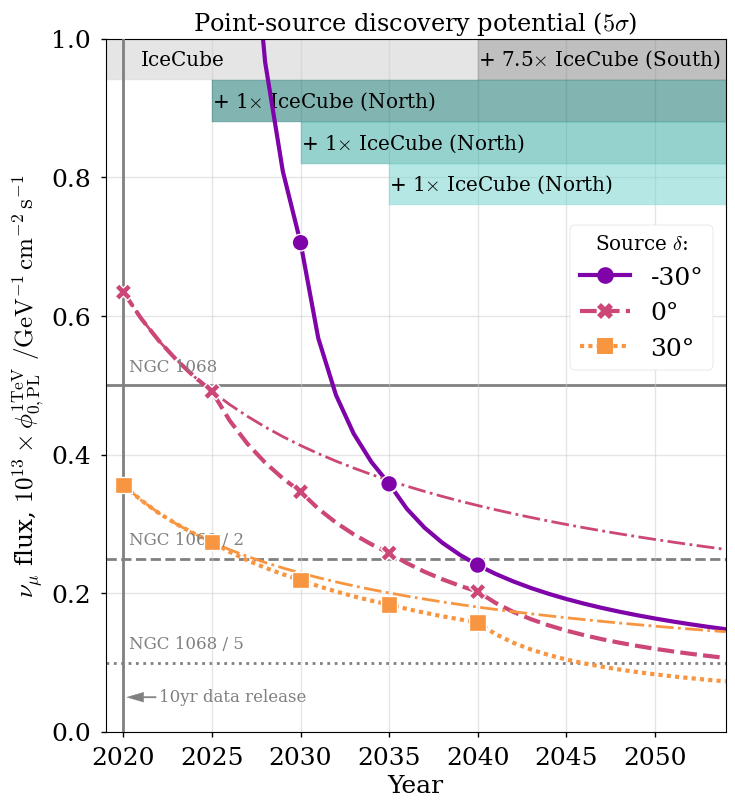

In [29]:
f, ax = plt.subplots(figsize=(8, 9))
# f, ax = plt.subplots(figsize=(6, 5))

edge = 1
ax.set_ylim(0, edge)
width = 0.6e-1
font_color = "0.5"
sigma_ref = 5
ax.axvline(2020, zorder=10, color=font_color)
ax.annotate(
    "10yr data release",
    (2020.2, 0.05),
    (2022, 0.05),
    ha="left",
    va="center",
    zorder=10,
    arrowprops=dict(width=1, headwidth=7, color=font_color),
    color=font_color,
    fontsize="large",
)

for yr_i, series in start_dates.iterrows():
    if "extrapolated" in yr_i:
        continue
    if not "Gen" in yr_i:
        edge -= width
    length = 50 if not yr_i == "IceCube" else series.end - series.Year
    # plot colored time-line patch on top
    ax.add_patch(
        Rectangle(
            (series.Year, edge),
            length,
            width,
            color=series.colors,
            zorder=1,
            alpha=0.5,
        )
    )
    ax.text(
        x=series.Year if yr_i != "IceCube" else 2021,
        y=edge + 0.5 * width,
        s=series.label,
        ha="left",
        va="center",
        fontsize="x-large",
        zorder=2,
    )
# plenum evolution
ax = sns.lineplot(
    data=flux.loc[(flux.sigma == sigma_ref) & (flux.identifier == "PLEnuM")],
    x="Year",
    y="scaled_flux",
    hue="dec_label",
    hue_order=["-30°", "0°", "30°"],
    style_order=["-30°", "0°", "30°"],
    style="dec_label",
    units="dec",
    lw=3,
    legend=False,
    palette="plasma",
)
# icecube-only extrapolated
ax = sns.lineplot(
    data=flux.loc[
        (flux.sigma == sigma_ref) & (flux.identifier == "IceCube extrapolated")
    ],
    x="Year",
    y="scaled_flux",
    hue="dec_label",
    hue_order=["-30°", "0°", "30°"],
    units="dec",
    lw=2,
    ls="-.",
    legend=False,
    palette="plasma",
)

selection = flux.loc[(flux.sigma == sigma_ref) & (flux.identifier == "PLEnuM")]
selection = selection.loc[(selection.Year < 2041) & (selection.Year % 5 == 0)]
ax = sns.scatterplot(
    data=selection,
    x="Year",
    y="scaled_flux",
    hue="dec_label",
    hue_order=["-30°", "0°", "30°"],
    style="dec_label",
    markers=["X", "s", "o"],
    s=12**2,
    palette="plasma",
    ax=ax,
    legend=False,
    zorder=11,
)
# extra plotting for legend
selection = flux.loc[(flux.sigma == sigma_ref) & (flux.identifier == "PLEnuM")]
selection = selection.loc[selection.Year == 2035]
ax = sns.lineplot(
    data=selection,
    x="Year",
    y="scaled_flux",
    hue="dec_label",
    hue_order=["-30°", "0°", "30°"],
    style_order=["-30°", "0°", "30°"],
    style="dec_label",
    units="dec",
    lw=3,
    ms=12,
    palette="plasma",
    markers=["o", "X", "s"],
)

legend = ax.legend(
    bbox_to_anchor=(1.0, 0.75),
    framealpha=1,
    loc=1,
    title="Source $\delta$:",
)
plt.setp(legend.get_title(), fontsize="x-large")
for line in legend.get_lines():
    line.set_linewidth(3)
    line.set_markersize(12)

ax.set_xlim(2019, yr_max - 1)
ax.set_ylabel(
    r"$\nu_\mu$ flux, $10^{13} \times \phi_{0, \rm PL}^{1\rm TeV} ~ / \rm GeV^{-1} \, cm^{-2} \, s^{-1}$",
)

for ii, _ls in zip([1, 2, 5], ["-", "--", ":"]):
    ax.axhline(st.PHI_NGC * 1e13 / ii, ls=_ls, lw=2, color=font_color, zorder=0)
    ax.text(
        x=2020 + 0.3,
        y=0.02 + st.PHI_NGC * 1e13 / ii,
        s="NGC 1068" if ii == 1 else f"NGC 1068 / {ii}",
        color=font_color,
        fontsize="large",
    )

ax.grid(alpha=0.5)
# ax.set_yscale("symlog", linthresh=0.1)
ax.set_title("Point-source discovery potential ($5 \sigma$)", fontsize="xx-large")
# f.tight_layout()
f.savefig("../../plots/ngc_paper/time_evolution_significance_ps.pdf")

### ratio

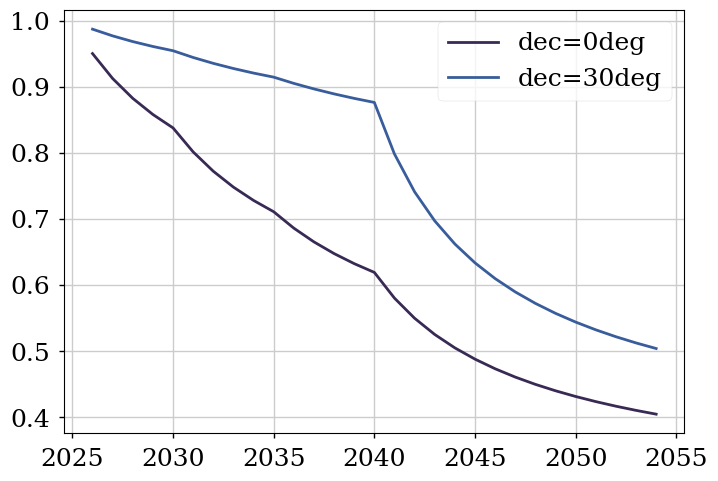

In [36]:
for idx, series in flux.groupby("dec"):
    if idx == -30:
       continue
    ratio = (
        series.loc[
            (series.sigma == sigma_ref)
            & (series.identifier == "PLEnuM")
            & (series.Year > 2025),
            "scaled_flux",
        ].values
        / series.loc[
            (series.sigma == sigma_ref)
            & (series.identifier == "IceCube extrapolated")
            & (series.Year > 2025),
            "scaled_flux",
        ].values
    )
    plt.plot(
        series.loc[
            (series.sigma == sigma_ref)
            & (series.identifier == "IceCube extrapolated")
            & (series.Year > 2025),
            "Year",
        ].values,
        ratio,
        label=f"dec={idx}deg",
    )
plt.legend()
#plt.yscale("log")

## spectral analysis

In [19]:
thresholds = [sigma3]  # , 0.01, 0.1]
decs = [-30, 0, 30]
detector_keys = ["IceCube" , "KM3NeT", "Baikal-GVD", "P-ONE", "Gen-2"]

tmp = []  # save output here

print("starting plenum timeline...")
for dec, yr_i in tqdm(product(decs, Years)):
    rad_dec = np.deg2rad(dec)

    # skip Southern Sky for IceCube-only config
    if dec < 0 and yr_i <= 2025:
        continue

    # insert the declination into the configs
    cur_bg_conf = bg_config.copy()
    cur_bg_conf["dec"] = rad_dec

    cur_sig_conf = src_config.copy()
    cur_sig_conf["dec"] = rad_dec

    time_factors = []
    cur_dets = []
    # generate the config for this particular year
    for ident in detector_keys:
        # skip calculation if detector isn't on yet
        if yr_i <= start_dates.loc[ident]["Year"]:
            continue

        # IceCube has an end-time within our time frame (=Gen2 start-time)
        # so it has a maximum contribution time here
        if (ident == "IceCube") and (yr_i >= start_dates.loc[ident]["end"]):
            new_rel_time = (
                start_dates.loc[ident]["end"] - start_dates.loc[ident]["Year"]
            ) / icecube_ref_time
        # otherwise, just calculate the diff between start time and current time
        else:
            new_rel_time = (yr_i - start_dates.loc[ident]["Year"]) / icecube_ref_time
        time_factors.append(new_rel_time)
        cur_dets.append(ident)

    conf = (cur_dets, time_factors)
    (
        all_aeff_factor_s,
        all_aeff_factor_b,
        all_k,
        all_bckg_flux,
        all_eres,
        all_k_b,
        all_k_s,
    ) = setup_multi_llh(
        improved_eres,  # select one resolution for all data sets
        conf,
        aeff_2d=aeff_2d,
        bckg_histo=bckg_histo,
        bg_config=cur_bg_conf,
        sig_config=cur_sig_conf,
        return_s_b=True,
        src_flux=ngc_cut_flux,
    )

    all_k_s = np.array(all_k_s)
    sum_s = np.sum(all_k_s)
    all_k_b = np.array(all_k_b)
    sum_b = np.sum(all_k_b)

    # calculate an estimate for the flux scaling
    scaler = 8 / (sum_s / np.sqrt(sum_b))
    current_thresholds = copy(thresholds)
    while len(current_thresholds) > 0:
        scaled_k_s = all_k_s * scaler
        all_k = scaled_k_s + all_k_b

        dct = dict(
            all_aeff_factor_s=all_aeff_factor_s,
            all_aeff_factor_b=all_aeff_factor_b,
            all_k=all_k,
            all_bckg_flux=all_bckg_flux,
            all_eres=all_eres,
            e_0=ngc_cut_flux.E0,
            phi_0=ngc_cut_flux.norm,
        )
        # fix signal contribution to powerlaw
        local_llh = lambda x: ps_llh_multi(x, shape="powerlaw", **dct)
        global_llh = lambda x: ps_llh_multi(x, shape="powerlaw with cutoff", **dct)
        out_bckg = fmin_l_bfgs_b(
            local_llh,
            x0=(1.2, 1.2, st.GAMMA_NGC),
            bounds=[(0, 10), (0, 10), (1, 5)],
            approx_grad=True,
        )

        out_comp = fmin_l_bfgs_b(
            global_llh,
            x0=(1.2, scaler, st.Gamma_cut, st.logE_cut),
            approx_grad=True,
        )
        pval = chi2.sf(out_bckg[1] - out_comp[1], 1)
        tmp_dct = {
            "identifier": "PLEnuM",
            "dec_label": f"{dec}°",
            "dec": dec,
            "Year": yr_i,
            "scaler": scaler,
            "cur_thresh": current_thresholds[0],
            "SosB": np.sum(scaled_k_s) / np.sqrt(np.sum(all_k_b)),
            "n_b": np.sum(all_k_b),
            "n_sig": np.sum(scaled_k_s),
            "log10(p)": -np.log10(pval),  # 1 ndof
            "pval": pval,
        }
        tmp.append(tmp_dct)
        tmp_df = pd.DataFrame(tmp)
        mask = (
            (tmp_df.dec == dec)
            & (tmp_df.Year == yr_i)
            & (tmp_df.cur_thresh == current_thresholds[0])
        )
        scaler = scaling_estimation(
            tmp_df.loc[mask],
            current_thresholds,
            scaler,
            stop_here=0.2,
            stepper=2,
            min_steps=1,
        )

        if scaler == -1:
            break

## same code, but IceCube-only extrapolation
thresholds = [sigma3]
decs = [0, 30]
# different energy resolutions for different detectors
eres_per_det = improved_eres
print("starting icecube-only timeline...")
for dec, yr_i in tqdm(product(decs, Years)):
    rad_dec = np.deg2rad(dec)

    # insert the declination into the configs
    cur_bg_conf = bg_config.copy()
    cur_bg_conf["dec"] = rad_dec

    cur_sig_conf = src_config.copy()
    cur_sig_conf["dec"] = rad_dec

    time_factors = []
    cur_dets = []
    # generate the config for this particular year
    ident = "IceCube extrapolated"
    # skip calculation if detector isn't on yet
    if yr_i <= start_dates.loc[ident]["Year"]:
        continue

    new_rel_time = (yr_i - start_dates.loc[ident]["Year"]) / icecube_ref_time
    time_factors.append(new_rel_time)
    cur_dets.append("IceCube")

    conf = (cur_dets, time_factors)
    (
        all_aeff_factor_s,
        all_aeff_factor_b,
        all_k,
        all_bckg_flux,
        all_eres,
        all_k_b,
        all_k_s,
    ) = setup_multi_llh(
        improved_eres,  # select one resolution for all data sets
        conf,
        aeff_2d=aeff_2d,
        bckg_histo=bckg_histo,
        bg_config=cur_bg_conf,
        sig_config=cur_sig_conf,
        return_s_b=True,
        src_flux=ngc_cut_flux,
    )

    all_k_s = np.array(all_k_s)
    all_k_b = np.array(all_k_b)

    # calculate an estimate for the flux scaling
    scaler = 8 / (np.sum(all_k_s) / np.sqrt(np.sum(all_k_b)))
    current_thresholds = copy(thresholds)
    while len(current_thresholds) > 0:
        scaled_k_s = all_k_s * scaler
        all_k = scaled_k_s + all_k_b

        dct = dict(
            all_aeff_factor_s=all_aeff_factor_s,
            all_aeff_factor_b=all_aeff_factor_b,
            all_k=all_k,
            all_bckg_flux=all_bckg_flux,
            all_eres=all_eres,
            e_0=ngc_cut_flux.E0,
            phi_0=ngc_cut_flux.norm,
        )
        # fix signal contribution to powerlaw
        local_llh = lambda x: ps_llh_multi(x, shape="powerlaw", **dct)
        global_llh = lambda x: ps_llh_multi(x, shape="powerlaw with cutoff", **dct)
        out_bckg = fmin_l_bfgs_b(
            local_llh,
            x0=(1.2, 1.2, st.GAMMA_NGC),
            bounds=[(0, 10), (0, 10), (1, 5)],
            approx_grad=True,
        )

        out_comp = fmin_l_bfgs_b(
            global_llh,
            x0=(1.2, scaler, st.Gamma_cut, st.logE_cut),
            approx_grad=True,
        )
        pval = chi2.sf(out_bckg[1] - out_comp[1], 1)  # 1 ndof
        tmp_dct = {
            "identifier": "IceCube extrapolated",
            "dec_label": f"{dec}°",
            "dec": dec,
            "Year": yr_i,
            "scaler": scaler,
            "cur_thresh": current_thresholds[0],
            "SosB": np.sum(scaled_k_s) / np.sqrt(np.sum(all_k_b)),
            "n_b": np.sum(all_k_b),
            "n_sig": np.sum(scaled_k_s),
            "log10(p)": -np.log10(pval), 
            "pval": pval,
        }
        tmp.append(tmp_dct)
        tmp_df = pd.DataFrame(tmp)
        mask = (
            (tmp_df.dec == dec)
            & (tmp_df.Year == yr_i)
            & (tmp_df.cur_thresh == current_thresholds[0])
            & (tmp_df.identifier == "IceCube extrapolated")
        )
        scaler = scaling_estimation(
            tmp_df.loc[mask], current_thresholds, scaler, stop_here=0.1
        )

        if scaler == -1:
            break


df = pd.DataFrame(tmp)

df.to_pickle(join(LOCALPATH, "timeline_disc_pot_spectral.pickle"))

starting plenum timeline...


0it [00:00, ?it/s]

105it [02:37,  1.50s/it]


starting icecube-only timeline...


70it [00:35,  2.00it/s]


### plotting

In [23]:
df = pd.read_pickle(join(LOCALPATH, "timeline_disc_pot_spectral.pickle"))

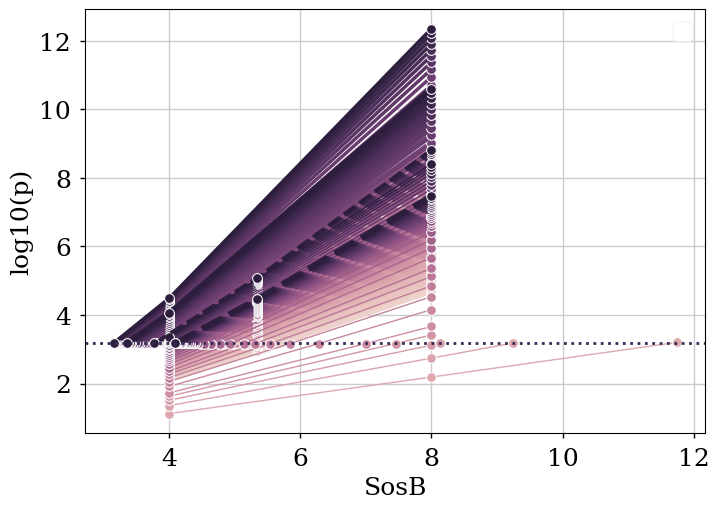

In [21]:
thresholds = [sigma3]
xname = "SosB"  # "scaler" #
ax = sns.lineplot(
    data=df,
    y="log10(p)",
    x=xname,
    marker="o",
    hue="Year",
    size="dec",
    style="identifier",
)
for t in thresholds:
    plt.axhline(-np.log10(t), ls=":")
plt.legend([])

In [30]:
df = pd.read_pickle(join(LOCALPATH, "timeline_disc_pot_spectral.pickle"))

flux = pd.DataFrame(
    df.groupby(["Year", "dec", "dec_label", "identifier"]).apply(
        lambda x: get_scaler(x, sigma3)
    )
    * ngc_cut_flux.norm,
    columns=["dp_flux"],
).reset_index()
flux["sigma"] = 3

flux["scaled_flux"] = flux.dp_flux * 1e13
flux.to_csv(join(LOCALPATH, "source_spectrum_time-evolution.csv"))

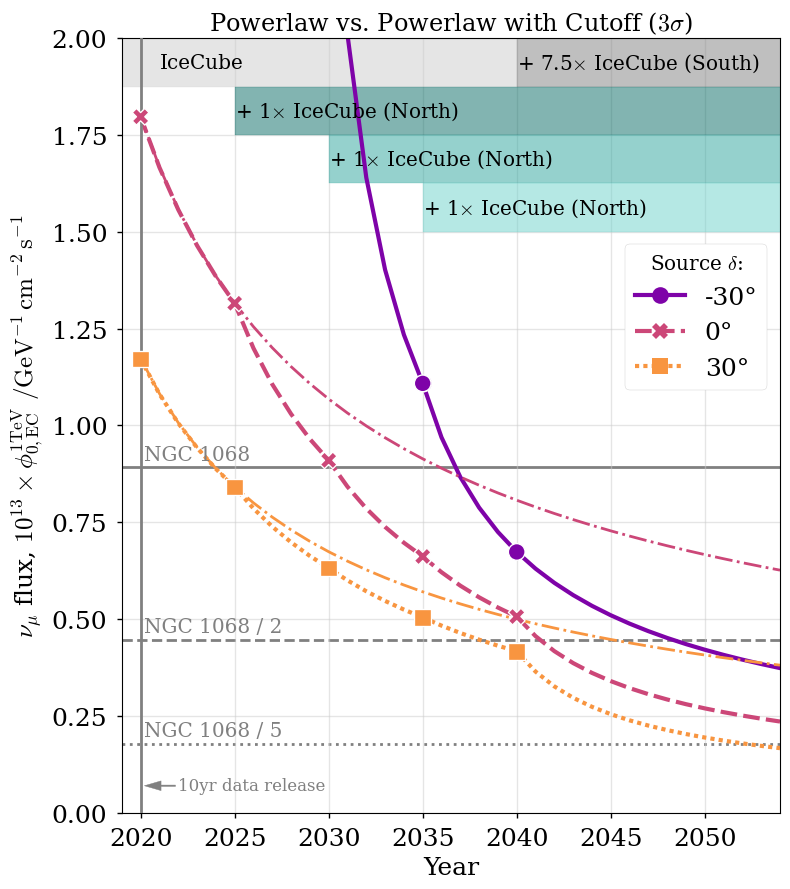

In [31]:
f, ax = plt.subplots(figsize=(8, 9))

edge = 2
ax.set_ylim(0, edge)

width = 1.25e-1
font_color = "0.5"

ax.axvline(2020, zorder=10, color=font_color)
ax.annotate(
    "10yr data release",
    (2020.2, 0.07),
    (2022, 0.07),
    ha="left",
    va="center",
    zorder=10,
    arrowprops=dict(width=1, headwidth=7, color=font_color),
    color=font_color,
    fontsize="large",
)

for yr_i, series in start_dates.iterrows():
    if "extrapolated" in yr_i:
        continue
    if not "Gen" in yr_i:
        edge -= width
    length = 50 if not yr_i == "IceCube" else series.end - series.Year
    ax.add_patch(
        Rectangle(
            (series.Year, edge), length, width, color=series.colors, zorder=1, alpha=0.5
        )
    )
    ax.text(
        x=series.Year if yr_i != "IceCube" else 2021,
        y=edge + 0.5 * width,
        s=series.label,
        ha="left",
        va="center",
        fontsize="x-large",
        zorder=20,
    )

ax = sns.lineplot(
    data=flux.loc[(flux.sigma == 3) & (flux.identifier == "PLEnuM")],
    x="Year",
    y="scaled_flux",
    hue="dec_label",
    hue_order=["-30°", "0°", "30°"],
    style_order=["-30°", "0°", "30°"],
    #dashes=[(1, 1), (1, 0), (2, 2)],
    style="dec_label",
    units="dec",
    lw=3,
    legend=False,
    palette="plasma",
)


selection = flux.loc[flux.sigma == 3]
selection = selection.loc[flux.identifier == "PLEnuM"]
selection = selection.loc[(selection.Year < 2041) & (selection.Year % 5 == 0)]
ax = sns.scatterplot(
    data=selection,
    x="Year",
    y="scaled_flux",
    hue="dec_label",
    hue_order=["-30°", "0°", "30°"],
    style="dec_label",
    markers=["X", "s", "o"],
    s=12**2,
    palette="plasma",
    ax=ax,
    legend=False,
    zorder=11,
)

selection = flux.loc[flux.sigma == 3]
selection = selection.loc[flux.identifier == "PLEnuM"]
selection = selection.loc[selection.Year == 2035]
ax = sns.lineplot(
    data=selection,
    x="Year",
    y="scaled_flux",
    hue="dec_label",
    hue_order=["-30°", "0°", "30°"],
    style_order=["-30°", "0°", "30°"],
    #dashes=[(1, 1), (1, 0), (2, 2)],
    style="dec_label",
    units="dec",
    lw=3,
    ms=12,
    palette="plasma",
    markers=["o", "X", "s"],
)
# icecube extrapolated
ax = sns.lineplot(
    data=flux.loc[(flux.sigma == 3) & (flux.identifier == "IceCube extrapolated")],
    x="Year",
    y="scaled_flux",
    hue="dec_label",
    hue_order=["-30°", "0°", "30°"],
    units="dec",
    lw=2, ls="-.",
    legend=False,
    palette="plasma",
)

legend = ax.legend(
    bbox_to_anchor=(1.0, 0.75),
    framealpha=1,
    loc=1,
    title="Source $\delta$:",
)
plt.setp(legend.get_title(), fontsize="x-large")
for line in legend.get_lines():
    line.set_linewidth(3)
    line.set_markersize(12)

ax.set_xlim(2019, yr_max - 1)
ax.set_ylabel(
    r"$\nu_\mu$ flux, $10^{13} \times \phi_{0, \rm EC}^{1\rm TeV} ~ / \rm GeV^{-1} \, cm^{-2} \, s^{-1}$",
)

for ii, _ls in zip([1, 2, 5], ["-", "--", ":"]):
    ax.axhline(ngc_cut_flux.norm * 1e13 / ii, ls=_ls, lw=2, color=font_color, zorder=0)
    ax.text(
        x=2020 + 0.2,
        y=0.02 + ngc_cut_flux.norm * 1e13 / ii,
        s="NGC 1068" if ii == 1 else f"NGC 1068 / {ii}",
        color=font_color,
        fontsize="x-large",
    )

ax.grid(alpha=0.5)

ax.set_title("Powerlaw vs. Powerlaw with Cutoff ($3 \sigma$)", fontsize="xx-large")
f.tight_layout()
f.savefig("../../plots/ngc_paper/time_evolution_significance_spectral.pdf")

### ratio

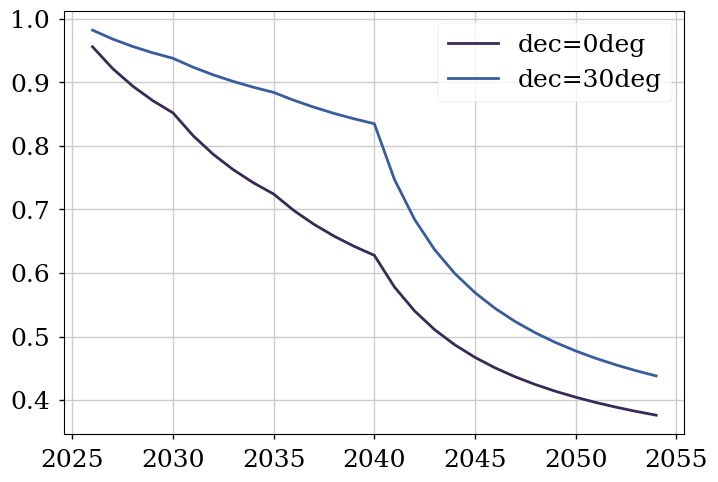

In [41]:
sigma_ref = 3
for idx, series in flux.groupby("dec"):
    if idx == -30:
       continue
    ratio = (
        series.loc[
            (series.sigma == sigma_ref)
            & (series.identifier == "PLEnuM")
            & (series.Year > 2025),
            "scaled_flux",
        ].values
        / series.loc[
            (series.sigma == sigma_ref)
            & (series.identifier == "IceCube extrapolated")
            & (series.Year > 2025),
            "scaled_flux",
        ].values
    )
    plt.plot(
        series.loc[
            (series.sigma == sigma_ref)
            & (series.identifier == "IceCube extrapolated")
            & (series.Year > 2025),
            "Year",
        ].values,
        ratio,
        label=f"dec={idx}deg",
    )
plt.legend()
#plt.yscale("log")